In [1]:
import pickle
import os
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
os.chdir("../../..")
print(os.getcwd())

/Users/titonka/FAIRIS


In [2]:
with open("data/VisualPlaceCellData/LM8_1000",'rb') as file:
    visual_place_cell_data = pickle.load(file)

In [4]:
n_clusters = 18  # You can change this based on how many clusters you expect

# Function to plot clusters on the x, y plane
def plot_clusters(xy_list, cluster_labels, name):
    """
    Plot the clusters on the x, y plane using the original (x, y) coordinates, and save the figure.

    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    - name (str): The filename to save the figure as (e.g., "clusters_plot.png").
    """
    # Convert xy_list to NumPy arrays for easy plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])

    # Check if the lengths match
    if len(x_coords) != len(cluster_labels):
        raise ValueError(f"Mismatch: {len(x_coords)} coordinates and {len(cluster_labels)} cluster labels.")

    # Scatter plot with color coding for clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_coords, y_coords, c=cluster_labels, cmap='rainbow', alpha=0.7)

    # Add color bar to indicate clusters
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Clustering with {len(set(cluster_labels))} Clusters on X-Y Plane')

    # Save the plot to the specified file
    plt.savefig(name)

    # Close the plot to avoid displaying it when running in scripts
    plt.close()


def plot_clusters_by_subplots(xy_list, cluster_labels, name, n_clusters=8):
    """
    Plot the clusters on 8 subplots, one for each cluster, using the original (x, y) coordinates.

    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    - n_clusters (int): Number of clusters to plot (default is 8).
    """
    # Convert xy_list to NumPy arrays for easy filtering and plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])

    # Create subplots (arranged as 4 rows, 2 columns for 8 clusters)
    fig, axes = plt.subplots(3, 6, figsize=(30, 20))  # 4 rows, 2 columns for 8 clusters
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Plot each cluster on its respective subplot
    for cluster_id in range(n_clusters):
        # Get the indices of the datapoints that belong to the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]

        # Filter x and y coordinates for the current cluster
        cluster_x = x_coords[cluster_indices]
        cluster_y = y_coords[cluster_indices]

        # Scatter plot for the current cluster
        axes[cluster_id].scatter(cluster_x, cluster_y, c=f'C{cluster_id}', alpha=0.7)

        # Set subplot title and labels
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].set_xlabel('X Coordinate')
        axes[cluster_id].set_ylabel('Y Coordinate')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    fig.savefig(name)
    plt.close()

def format_data_for_clustering(data):
    multimodal_feature_vectors = []
    cnn_feature_vectors = []
    xy_list = []
    theta_list = []
    for observation in data.observations:
        multimodal_feature_vectors.append(observation.multimodal_feature_vector)
        cnn_feature_vectors.append(observation.cnn_feature_vector)
        xy_list.append((observation.x, observation.y))
        theta_list.append(observation.theta)

    return multimodal_feature_vectors, cnn_feature_vectors, xy_list, theta_list

multimodal_feature_vectors,cnn_feature_vectors,xy_list,theta_list = format_data_for_clustering(visual_place_cell_data)
def cluster_with_kmeans_and_save_centers(features_list, n_clusters, centers_save_path):
    """
    Perform KMeans clustering, calculate the maximum distance for each cluster,
    and save the cluster centers and max distances as a list of lists using pickle.

    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to form.
    - centers_save_path (str): Path to save the cluster centers and max distances using pickle.

    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    - cluster_centers (numpy array): The centers of the final clusters.
    """
    features_array = np.array(features_list)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_array)

    # Get cluster centers and labels for each data point
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # List to store [center, max_distance] for each cluster
    cluster_data = []

    # Calculate max distance for each cluster
    for cluster_index in range(n_clusters):
        # Get data points belonging to this cluster
        cluster_points = features_array[labels == cluster_index]

        # Calculate distances from each point to the cluster center
        distances = cdist(cluster_points, [cluster_centers[cluster_index]], metric='euclidean').flatten()

        # Find the maximum distance for this cluster
        max_distance = distances.max()

        # Append the center and max distance as a pair to cluster_data
        cluster_data.append([cluster_centers[cluster_index].tolist(), max_distance])

    # Save cluster_data (centers and max distances) using pickle
    with open(centers_save_path, 'wb') as f:
        pickle.dump(cluster_data, f)

    return cluster_labels

centers_save_path = "data/VisualPlaceCellData/VisualPlaceCellClusters/multimodal_kmeans_centers"
cluster_labels = cluster_with_kmeans_and_save_centers(multimodal_feature_vectors, n_clusters, centers_save_path)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels, "data/figures/Clustering/multi_model_knn.png")
plot_clusters_by_subplots(xy_list, cluster_labels, "data/figures/Clustering/multimodel_knn_clusters.png", n_clusters=n_clusters)

centers_save_path = "data/VisualPlaceCellData/VisualPlaceCellClusters/cnn_kmeans_centers"
cluster_labels = cluster_with_kmeans_and_save_centers(cnn_feature_vectors, n_clusters, centers_save_path)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels, "data/figures/Clustering/cnn_knn.png")
plot_clusters_by_subplots(xy_list, cluster_labels, "data/figures/Clustering/cnn_knn_clusters.png", n_clusters=n_clusters)

# Function to perform Birch clustering and save the model and cluster centers
def cluster_with_birch_and_save_centers(features_list, n_clusters, model_save_path, centers_save_path):
    """
    Perform Birch clustering, approximate the cluster centers by averaging the points in each cluster,
    calculate the maximum distance of points to their cluster center, and save the centers with distances.

    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to form.
    - model_save_path (str): Path to save the trained Birch model using pickle.
    - centers_save_path (str): Path to save the cluster centers and max distances as a Python list using pickle.

    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    - cluster_centers (numpy array): The approximate centers of the final clusters.
    """
    features_array = np.array(features_list)

    # Perform Birch clustering
    birch = Birch(n_clusters=n_clusters)
    cluster_labels = birch.fit_predict(features_array)

    # Save the Birch model
    with open(model_save_path, 'wb') as f:
        pickle.dump(birch, f)

    # List to store [center, max_distance] for each cluster
    cluster_data = []

    # For each final cluster, calculate the center and max distance
    for cluster_id in range(n_clusters):
        # Get the feature vectors for the points in this cluster
        cluster_points = features_array[cluster_labels == cluster_id]

        # Compute the center by averaging the points in this cluster
        if len(cluster_points) > 0:
            cluster_center = np.mean(cluster_points, axis=0)
        else:
            # In case a cluster has no points (unlikely), set a zero vector
            cluster_center = np.zeros(features_array.shape[1])

        # Calculate distances from each point to the cluster center
        distances = cdist(cluster_points, [cluster_center], metric='euclidean').flatten()

        # Find the maximum distance
        max_distance = distances.max() if len(distances) > 0 else 0

        # Append the center and max distance as a pair to cluster_data
        cluster_data.append([cluster_center.tolist(), max_distance])

    # Save cluster_data (centers and max distances) using pickle
    with open(centers_save_path, 'wb') as f:
        pickle.dump(cluster_data, f)

    return cluster_labels

centers_save_path = "data/VisualPlaceCellData/VisualPlaceCellClusters/multimodal_birch_centers"
cluster_labels = cluster_with_birch_and_save_centers(multimodal_feature_vectors, n_clusters, centers_save_path)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels, "data/figures/Clustering/multi_model_birch.png")
plot_clusters_by_subplots(xy_list, cluster_labels, "data/figures/Clustering/multimodel_birch_clusters.png", n_clusters=n_clusters)

centers_save_path = "data/VisualPlaceCellData/VisualPlaceCellClusters/cnn_birch_centers"
cluster_labels = cluster_with_birch_and_save_centers(cnn_feature_vectors, n_clusters, centers_save_path)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels, "data/figures/Clustering/cnn_birch.png")
plot_clusters_by_subplots(xy_list, cluster_labels, "data/figures/Clustering/cnn_birch_clusters.png", n_clusters=n_clusters)

TypeError: cluster_with_birch_and_save_centers() missing 1 required positional argument: 'centers_save_path'

In [3]:
def format_data_for_clustering(data):
    multimodal_feature_vectors = []
    cnn_feature_vectors = []
    xy_list = []
    theta_list = []
    for observation in data.observations:
        multimodal_feature_vectors.append(observation.multimodal_feature_vector)
        cnn_feature_vectors.append(observation.cnn_feature_vector)
        xy_list.append((observation.x, observation.y))
        theta_list.append(observation.theta)
        
    return multimodal_feature_vectors,cnn_feature_vectors,xy_list,theta_list
        
        

In [4]:
multimodal_feature_vectors,cnn_feature_vectors,xy_list,theta_list = format_data_for_clustering(visual_place_cell_data)

## Clustering Plots

In [7]:
# Function to plot clusters on the x, y plane
def plot_clusters(xy_list, cluster_labels):
    """
    Plot the clusters on the x, y plane using the original (x, y) coordinates.
    
    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert xy_list to NumPy arrays for easy plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])

    # Check if the lengths match
    if len(x_coords) != len(cluster_labels):
        raise ValueError(f"Mismatch: {len(x_coords)} coordinates and {len(cluster_labels)} cluster labels.")

    # Scatter plot with color coding for clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_coords, y_coords, c=cluster_labels, cmap='rainbow', alpha=0.7)

    # Add color bar to indicate clusters
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'KMeans Clustering with {len(set(cluster_labels))} Clusters on X-Y Plane')

    # Show the plot
    plt.show()
    
    
def plot_clusters_by_subplots(xy_list, cluster_labels, n_clusters=8):
    """
    Plot the clusters on 8 subplots, one for each cluster, using the original (x, y) coordinates.
    
    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    - n_clusters (int): Number of clusters to plot (default is 8).
    """
    # Convert xy_list to NumPy arrays for easy filtering and plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])
    
    # Create subplots (arranged as 4 rows, 2 columns for 8 clusters)
    fig, axes = plt.subplots(2, 4, figsize=(16, 10))  # 4 rows, 2 columns for 8 clusters
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    # Plot each cluster on its respective subplot
    for cluster_id in range(n_clusters):
        # Get the indices of the datapoints that belong to the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        
        # Filter x and y coordinates for the current cluster
        cluster_x = x_coords[cluster_indices]
        cluster_y = y_coords[cluster_indices]
        
        # Scatter plot for the current cluster
        axes[cluster_id].scatter(cluster_x, cluster_y, c=f'C{cluster_id}', alpha=0.7)
        
        # Set subplot title and labels
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].set_xlabel('X Coordinate')
        axes[cluster_id].set_ylabel('Y Coordinate')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Uses ResNET50 to extract features from the images captured by the onboard camera

# KMean Clustering

In [5]:
# Function to perform KMeans clustering
def cluster_with_kmeans(features_list, n_clusters):
    """
    Perform KMeans clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to form.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for KMeans
    features_array = np.array(features_list)
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Set random_state for reproducibility
    cluster_labels = kmeans.fit_predict(features_array)
    
    return cluster_labels

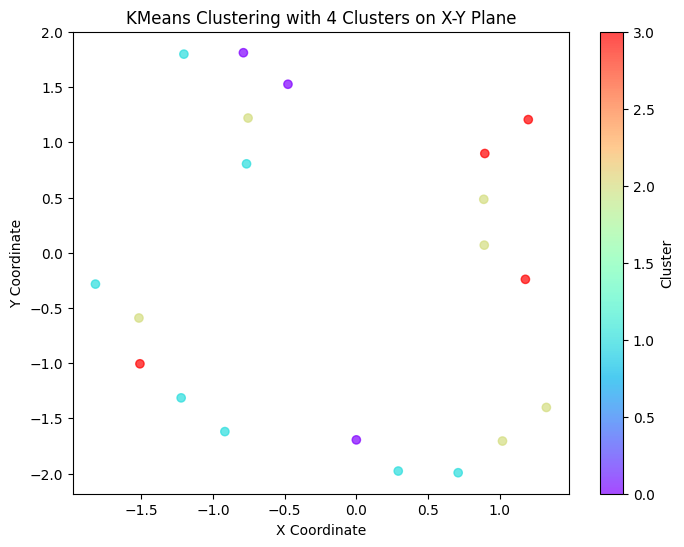

In [13]:
n_clusters = 4  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_kmeans(multimodal_feature_vectors, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

In [16]:
print(len(multimodal_feature_vectors[0]))
print(len(cnn_feature_vectors[0]))

7374
614400


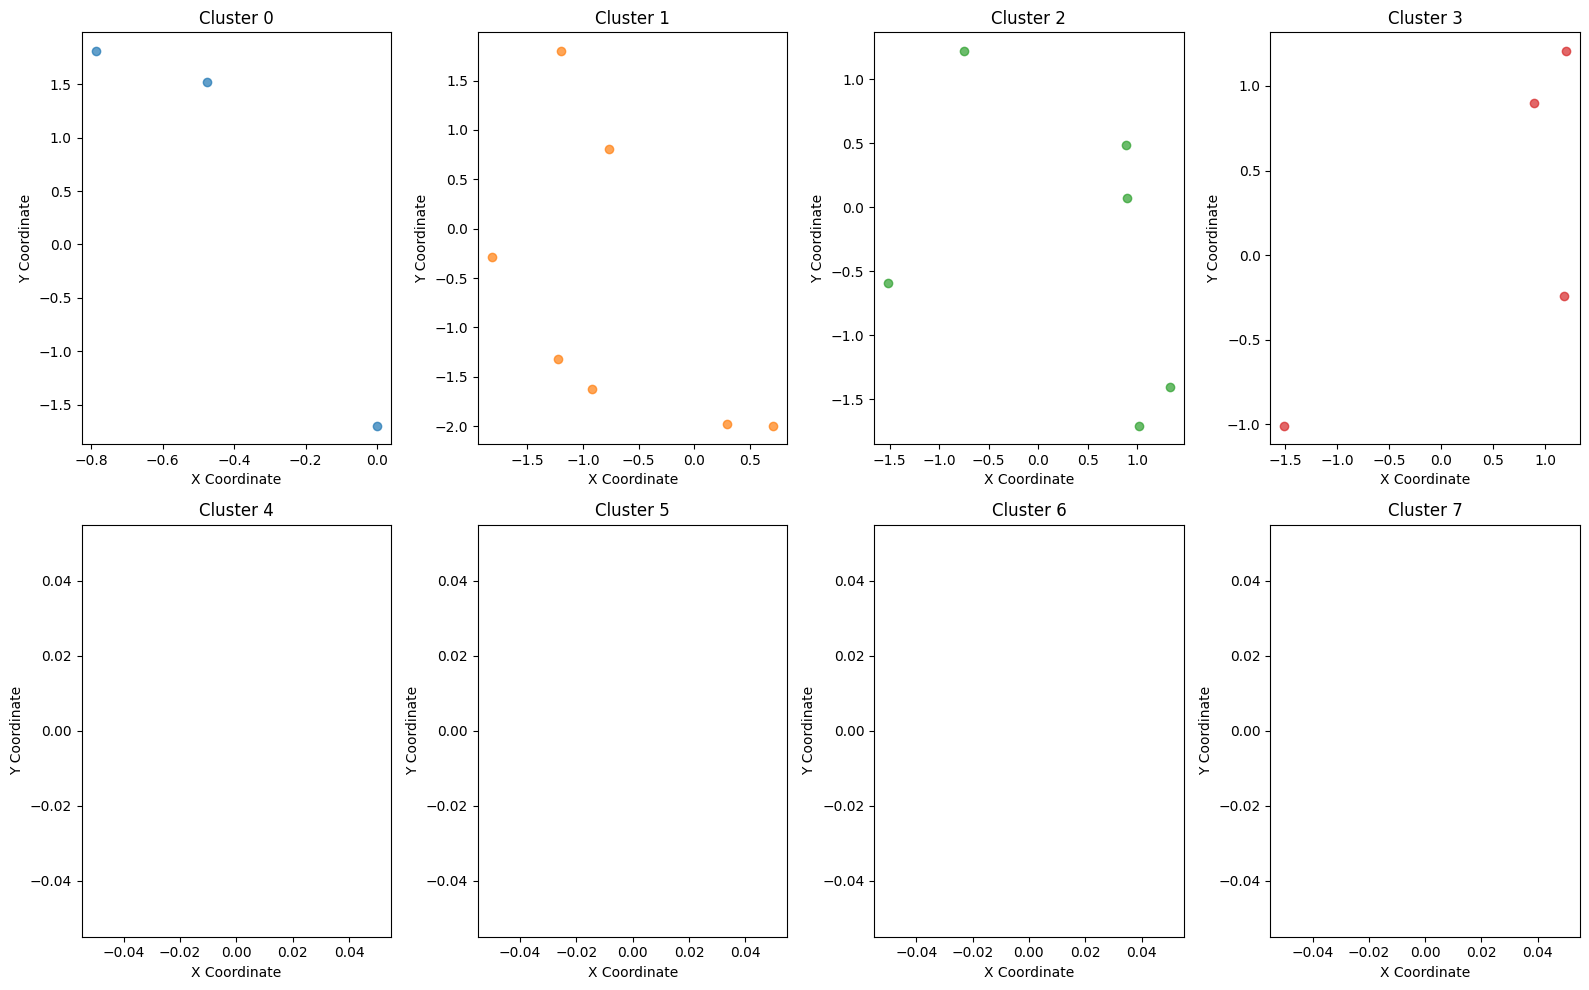

In [14]:
plot_clusters_by_subplots(xy_list, cluster_labels, n_clusters=8)

In [8]:
def cluster_with_dbscan(features_list, eps=0.5, min_samples=5):
    """
    Perform DBSCAN clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood.
    - min_samples (int): The number of samples in a neighborhood for a point to be considered a core point.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint. Points classified as noise are labeled as -1.
    """
    # Convert feature list to a NumPy array for DBSCAN
    features_array = np.array(features_list)
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(features_array)
    
    return cluster_labels

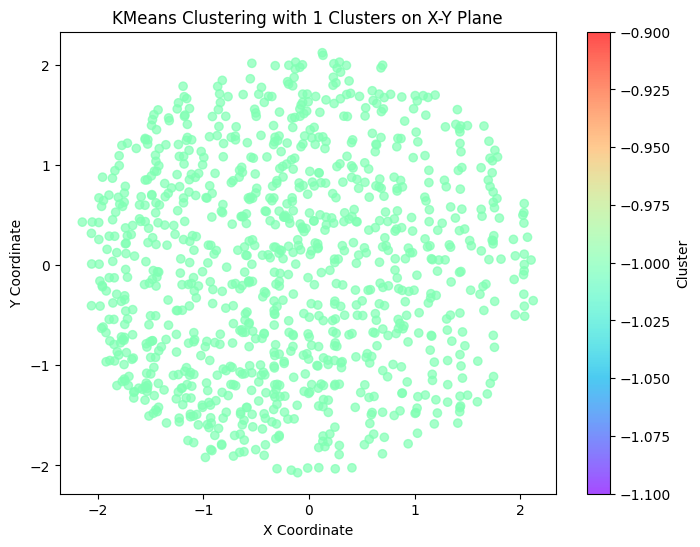

In [9]:
cluster_labels = cluster_with_dbscan(features)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

# Agglomerative Hierarchical Clustering 
   - How It Works: This method recursively merges pairs of clusters based on the similarity of their points, forming a hierarchy of clusters. You can visualize the clustering process using a dendrogram and then cut the dendrogram to get the desired number of clusters.
   - When to Use:
      - When you want to explore hierarchical structures in your data.
      - When you don't want to specify the number of clusters in advance and want to try different levels of granularity.
   - Pros: Does not require specifying the number of clusters up front. Produces a hierarchy of clusters. Easy to visualize with a dendrogram.
   - Cons: Computationally expensive for large datasets.

In [10]:
def cluster_with_agglomerative(features_list, n_clusters=8):
    """
    Perform Agglomerative Clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to find.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for Agglomerative Clustering
    features_array = np.array(features_list)
    
    # Perform Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative.fit_predict(features_array)
    
    return cluster_labels

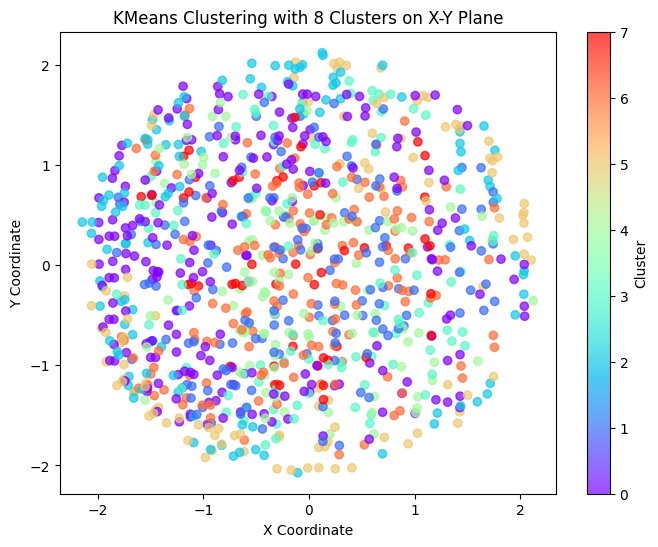

In [11]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_agglomerative(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

# Spectral Clustering
  - How It Works: Spectral clustering transforms the data into a lower-dimensional space using the eigenvalues of a similarity matrix derived from the data, and then clusters the data in that new space. It is particularly useful for clustering non-linearly separable data.
  - When to Use:
    -  When the data is non-linearly separable, and clusters have complex shapes.
  - Pros: Effective for non-linearly separable data. Can find complex-shaped clusters.
  - Cons: Computationally expensive. Requires predefining the number of clusters.

In [12]:
def cluster_with_spectral(features_list, n_clusters=8):
    """
    Perform Spectral Clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to find.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for Spectral Clustering
    features_array = np.array(features_list)
    
    # Perform Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(features_array)
    
    return cluster_labels

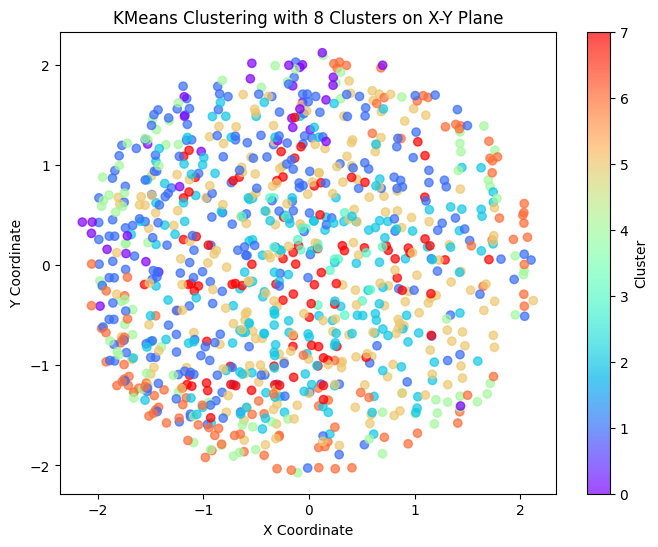

In [13]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_spectral(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

# Gaussian Mixture Models (GMM)
  - How IT Works:GMM assumes that the data is generated from a mixture of several Gaussian distributions, each with its own mean and variance. The algorithm assigns probabilities to each point belonging to a particular cluster.
  - When to Use:
    -  When you want soft clustering (i.e., points can belong to more than one cluster with a probability).
    -  When you expect your data to follow a Gaussian distribution within each cluster.
  - Pros: Provides probabilistic clustering (soft assignment). Can model more complex cluster shapes.
  - Cons: Requires specifying the number of clusters. Assumes Gaussian distribution of clusters.

In [14]:
def cluster_with_gmm(features_list, n_clusters=8):
    """
    Perform Gaussian Mixture Model (GMM) clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to find.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for GMM
    features_array = np.array(features_list)
    
    # Perform GMM clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(features_array)
    cluster_labels = gmm.predict(features_array)
    
    return cluster_labels

In [ ]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_gmm(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)

# Birch (Balanced Iterative Reducing and Clustering using Hierarchies)
  - How it Works: BIRCH builds a tree (called the Clustering Feature Tree) with nodes that summarize information about the data. The tree is then used to perform clustering.
  - When to Use:
    - When you need a memory-efficient clustering technique.
    - When dealing with very large datasets where a single pass over the data is required.
  - Pros: Works well on large datasets. Can be more memory-efficient than other clustering methods.
  - Cons:  Not suitable for non-spherical clusters.

In [ ]:
def cluster_with_birch(features_list, n_clusters=8):
    """
    Perform BIRCH clustering on the extracted features.
    
    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to find.
    
    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    """
    # Convert feature list to a NumPy array for BIRCH
    features_array = np.array(features_list)
    
    # Perform BIRCH clustering
    birch = Birch(n_clusters=n_clusters)
    cluster_labels = birch.fit_predict(features_array)
    
    return cluster_labels

In [ ]:
n_clusters = 8  # You can change this based on how many clusters you expect
cluster_labels = cluster_with_birch(features, n_clusters)

# Now plot the clusters
plot_clusters(xy_list, cluster_labels)